In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [3]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [5]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def envelope(y, rate, threshold): #to detect whteher the signal magnitude has already decayed and ignorable
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [7]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [8]:
df = pd.read_csv('C:/Users/hp/Desktop/Audio-Classification-v4/sound.csv')
df.set_index('fname', inplace = True)

In [9]:
for f in df.index:
    rate, signal = wavfile.read('C:/Users/hp/Desktop/Audio-Classification-v4/wavfiles/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

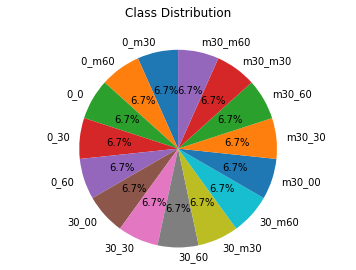

In [10]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y = 1.08)
ax.pie(class_dist, labels=class_dist.index, autopct = '%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [11]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.label == c].iloc[0,0]
    signal, rate = librosa.load('wavfiles/'+wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T #int 44100hz/40  
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

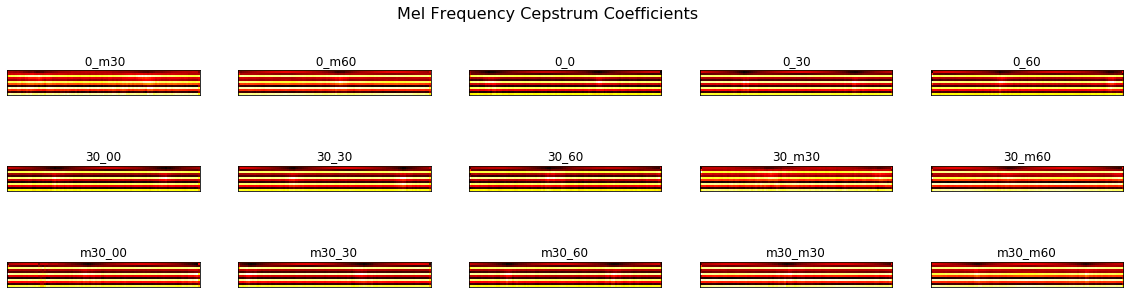

In [12]:
#plot_signals(signals)
#plt.show()

#plot_fft(fft)
#plt.show()
    
#plot_fbank(fbank)
#plt.show()

plot_mfccs(mfccs)
plt.show()

In [13]:
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles/'+f, sr=44100) #downsample
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])

100%|██████████████████████████████████████| 2700/2700 [05:59<00:00, 15.82it/s]
